In [1]:
import os
import sys

cwd = os.getcwd().split('/')
sys.path.append(os.path.join('/', *cwd[:cwd.index('discretizer')+1]))

In [2]:
from discretizer import tb_hamiltonian
from discretizer import momentum_operators

import sympy
import sympy.physics
from sympy.physics.quantum import TensorProduct as kr

In [3]:
sympy.init_printing(use_latex=True, pretty_print=True, wrap_line=False)

In [4]:
s0 = sympy.eye(2)
sx = sympy.physics.matrices.msigma(1)
sy = sympy.physics.matrices.msigma(2)
sz = sympy.physics.matrices.msigma(3)

kx, ky, kz = momentum_operators
A, B, D, M, C = sympy.symbols('A B D M C', real=True)


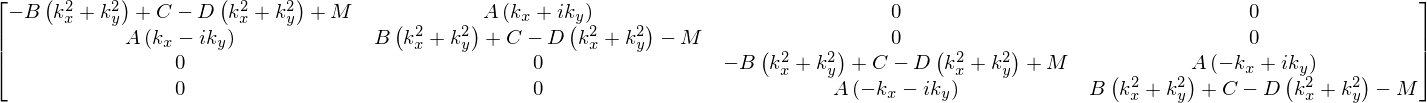

In [5]:
k = sympy.sqrt(kx**2+ky**2)
hamiltonian = (+ C * kr(s0, s0) + M * kr(s0, sz) - D * k**2 * kr(s0, s0) 
               - B * k**2 * kr(s0, sz) + A * (kx * kr(sz, sx) - ky * kr(s0, sy)))

hamiltonian

In [6]:
symbolic = tb_hamiltonian(hamiltonian, verbose=False, symbolic_output=True)

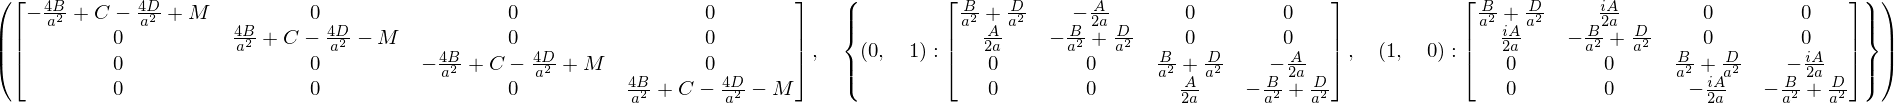

In [7]:
symbolic

In [8]:
discrete = tb_hamiltonian(hamiltonian, verbose=True)

Discrete coordinates set to:  ['x', 'y']

Function generated for (0, 1):
def _anonymous_func(site1, site2, p):
    y, x = site2.pos
    a, B, A, D = p.a, p.B, p.A, p.D
    return (np.array([[B/a**2 + D/a**2, -A/(2*a), 0, 0], [A/(2*a), -B/a**2 + D/a**2, 0, 0], [0, 0, B/a**2 + D/a**2, -A/(2*a)], [0, 0, A/(2*a), -B/a**2 + D/a**2]]))

Function generated for (1, 0):
def _anonymous_func(site1, site2, p):
    y, x = site2.pos
    a, B, A, D = p.a, p.B, p.A, p.D
    return (np.array([[B/a**2 + D/a**2, 1.j*A/(2*a), 0, 0], [1.j*A/(2*a), -B/a**2 + D/a**2, 0, 0], [0, 0, B/a**2 + D/a**2, -1.j*A/(2*a)], [0, 0, -1.j*A/(2*a), -B/a**2 + D/a**2]]))

Function generated for (0, 0):
def _anonymous_func(site, p):
    y, x = site.pos
    C, a, B, D, M = p.C, p.a, p.B, p.D, p.M
    return (np.array([[-4*B/a**2 + C - 4*D/a**2 + M, 0, 0, 0], [0, 4*B/a**2 + C - 4*D/a**2 - M, 0, 0], [0, 0, -4*B/a**2 + C - 4*D/a**2 + M, 0], [0, 0, 0, 4*B/a**2 + C - 4*D/a**2 - M]]))



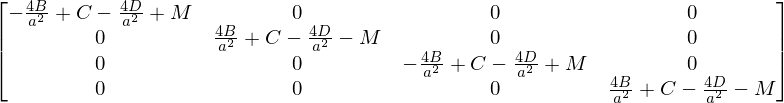

In [9]:
A, B, D, M, C = sympy.symbols('A B D M C')
a = sympy.Symbol('a')
A, B, D, M, C = A / 2 / a, B / a**2, D / a**2, M, C
C*kr(s0, s0) + (M - 4 * B) * kr(s0, sz) - 4 * D * kr(s0, s0)

In [10]:
import kwant
import matplotlib
%matplotlib inline

from collections import namedtuple
nt_bhz = namedtuple('nt_bhz', 'A B C D M, a')

def get_params(a=1, material='HgTe'):
    params = {
        "HgTe" : nt_bhz(A=3.65, B=-68.6, D=-51.1, M=-0.01, a=a, C=0),
        "InAs/GaSb" : nt_bhz(A=0.37, B=-66.0, D=-5.8, M=-0.0075, a=a, C=0)
    }
    return params['HgTe']

In [17]:
def make_system(discrete, W, L): 
    ons, hops = discrete
    def shape(pos):
        (x, y) = pos
        return (0 <= y < W and 0 <= x < L)
    
    def lead_shape(pos):
        (x, y) = pos
        return (0 <= y < W)

    lat = kwant.lattice.square()
    sys = kwant.Builder()
    lead = kwant.Builder(kwant.TranslationalSymmetry((-1, 0)))    

    sys[lat.shape(shape, (0, 0))] = ons
    sys[kwant.HoppingKind((1, 0), lat)] = hops[1,0]
    sys[kwant.HoppingKind((0, 1), lat)] = hops[0,1]
    
    lead[lat.shape(lead_shape, (0,0))] = ons
    lead[kwant.HoppingKind((1, 0), lat)] = hops[1,0]
    lead[kwant.HoppingKind((0, 1), lat)] = hops[0,1]
    
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())
    
    return sys

In [18]:
import numpy as np

In [19]:
import matplotlib.pyplot as plt

In [20]:
def plot_bs(W, material):
    print("width =", W, ", material =", material)
    sys = make_system(discrete, L=5, W=W).finalized()
    p = get_params(a=10, material=material)
    
    kwant.plotter.bands(sys.leads[0], args=[p], momenta=np.linspace(-0.3, 0.3, 100, endpoint=False), show=False)
    if material == "HgTe":
        plt.ylim(-0.05, 0.05)
    else:
        plt.ylim(-0.02, 0.02)

width = 100 , material = HgTe
CPU times: user 3.68 s, sys: 96 ms, total: 3.78 s
Wall time: 3.78 s


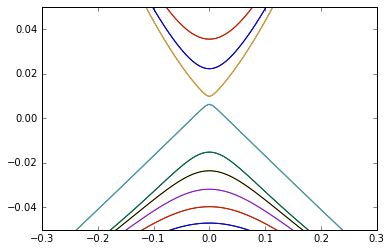

In [21]:
%%time
plot_bs(100, 'HgTe')